In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read Files

In [3]:
# normalized data, with GA effect
data = pd.read_csv("esetSC2_normalized.csv")

# data here is normalized, and the GA effect is removed.
#data = pd.read_csv("esetSC2_remove_effect.csv")

# data information
data_info = pd.read_csv('anoSC2_v20_nokey.csv')

data_infomation = data_info.reset_index().set_index("SampleID").drop(columns = 'index')
data_infomation = data_infomation.loc[data.columns]
data_infomation = data_infomation[(data_infomation['Group']=='Control') | (data_infomation['Group']=='sPTD')]
data = data[data_infomation.index]

## Heatmap

In [4]:
control_sample = []
sPTD_sample = []
for i in data_infomation.index:
    if i in data.columns.values:
        if data_infomation.loc[[i]][['Group']].values[0][0] == 'Control':
            control_sample.append(i)
        if data_infomation.loc[[i]][['Group']].values[0][0] == 'sPTD':
            sPTD_sample.append(i)
heatmap_data = data[control_sample + sPTD_sample]

In [5]:
df = heatmap_data
df = df.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)
df[['Control_mean', 'Control_std']] = df[control_sample].agg(['mean', 'std'], axis=1)
df[['sPTD_mean', 'sPTD_std']] = df[sPTD_sample].agg(['mean', 'std'], axis=1)
def welch_t_test(row):
    return (
        (row['Control_mean'] - row['sPTD_mean']) / 
        np.sqrt(row['Control_std']/len(control_sample) + row['sPTD_std']/len(sPTD_sample))
    )
df['similarity'] = df[['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std']].apply(welch_t_test, axis=1)
df.head()

,GSM1437801,GSM1437802,GSM1437803,GSM1437804,GSM1437805,GSM1437806,GSM1437807,GSM1437808,GSM1437811,GSM1437812,...,GSM1438078,GSM1438095,GSM1438096,GSM1438107,GSM1438108,Control_mean,Control_std,sPTD_mean,sPTD_std,similarity
1_at,0.144988,0.218802,-0.031543,-1.591526,-1.095856,0.572097,0.698646,1.757886,0.452732,1.146449,...,0.457580,-1.409763,0.132421,-0.739441,1.334354,0.009992,1.002488,-0.080647,1.012407,0.449871
10_at,-0.052884,2.936905,1.738092,0.324455,0.072913,-0.408800,-0.276935,-0.885517,-0.784513,-1.013414,...,1.689062,0.685459,1.643290,1.805022,-0.727365,-0.022053,0.957736,0.177997,1.314025,-0.884385
100_at,-0.871844,-1.682647,1.152734,0.569183,-1.073435,-0.154285,-0.055887,0.529392,0.789343,0.008832,...,-1.461276,-0.911580,1.322077,-0.628486,-1.045085,0.048401,0.997086,-0.390665,0.971954,2.219756
1000_at,0.192746,0.902999,-0.571080,0.629048,0.509008,-0.083502,-0.442473,-0.368351,0.798768,1.143935,...,-0.583723,-0.088121,-0.128905,0.657416,0.155889,0.024929,1.011187,-0.201214,0.916183,1.172572
10000_at,1.444900,1.640470,0.453117,0.713643,-0.362102,-0.362102,0.587632,0.086561,-2.307732,-2.648306,...,-1.766747,2.376528,0.321610,0.295741,-0.935664,0.025669,0.986661,-0.207189,1.115739,1.107426


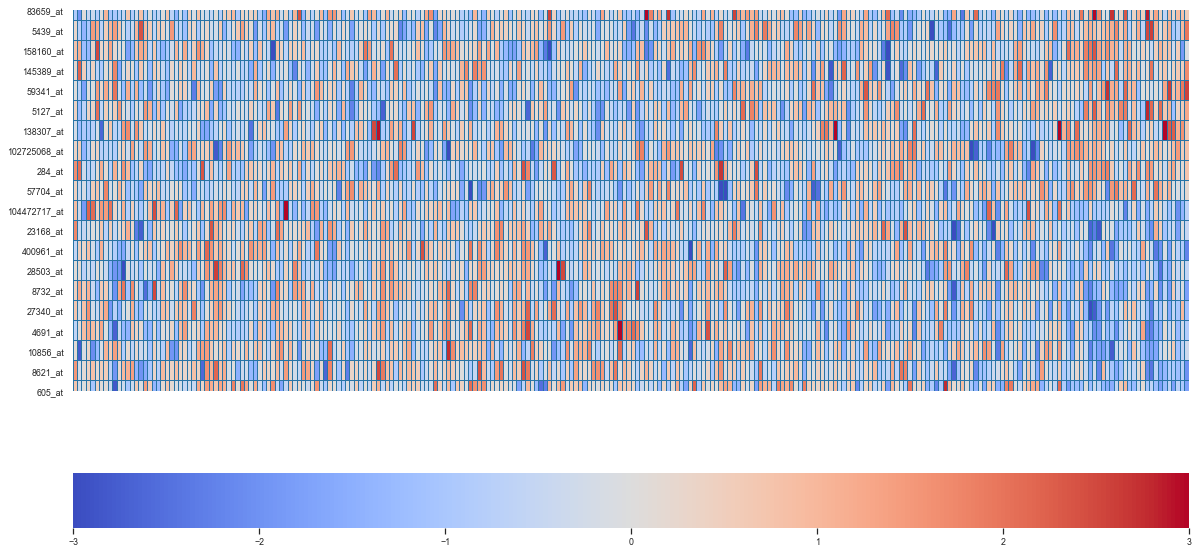

In [6]:
df_sorted = df.sort_values('similarity').\
drop(columns=['Control_mean', 'Control_std', 'sPTD_mean', 'sPTD_std', 'similarity'])
df_features = df_sorted.head(10).append(df_sorted.tail(10))
sns.set(font_scale=0.8)
plt.figure(figsize=(20,10))
sns.heatmap(cmap="coolwarm", vmin=-3, vmax=3, center=0, data=df_features, \
            xticklabels=False, linewidth=0.004, linecolor="#2874A6",\
            cbar_kws={"orientation": "horizontal"})

## Split the data into train and test

In [7]:
def SampleList_To_Group(sample_list, data_infomation = data_infomation):
    control_sample = []
    sPTD_sample = []
    sample_group = []
    for sample in sample_list:
        group = data_infomation.loc[[sample]][['Group']].values[0][0]
        if group == 'Control':
            control_sample.append(sample)
            sample_group.append('Control')
        if group == 'sPTD':
            sPTD_sample.append(sample)
            sample_group.append('sPTD')
    return sample_group, control_sample, sPTD_sample

In [8]:
df = data
sample_list = list(df.columns)
sample_group, control_sample, sPTD_sample = SampleList_To_Group(sample_list)
xtrain,xtest,ytrain,ytest = train_test_split(df.transpose(), sample_group,test_size=0.2, random_state=1)

## Prediction

In [9]:
# FROM SKLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

# THIS FUNCTION DOES NOT WORK WELL WITH ONLY 2 CLASSES

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## KNN

Confusion matrix, without normalization
[[ 1  3]
 [ 1 46]]
(2, 2)


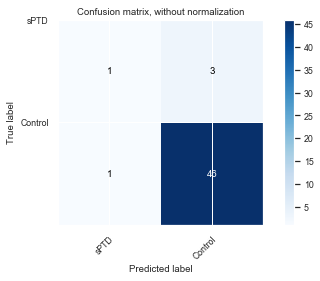

In [10]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Random Forest

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


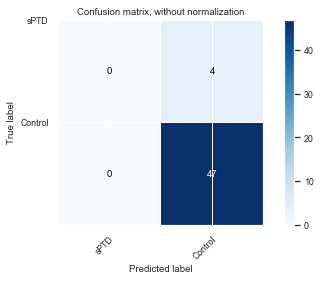

In [11]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Gaussian Naive Bayes

Confusion matrix, without normalization
[[ 0  4]
 [ 2 45]]
(2, 2)


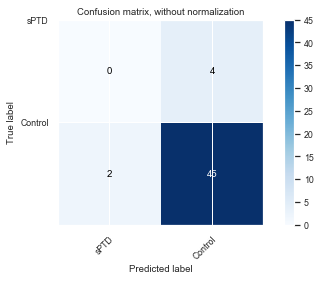

In [12]:
clf = GaussianNB()
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Support Vector Machine

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


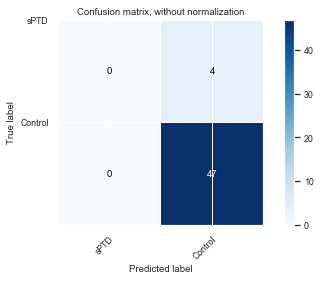

In [13]:
clf = svm.SVC(gamma='scale')
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Logistic Regression

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


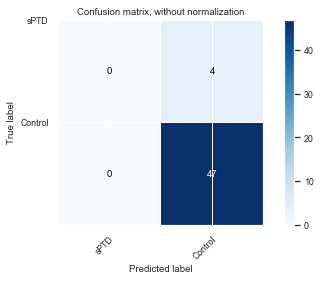

In [14]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)

## Linear Discriminant Analysis

Confusion matrix, without normalization
[[ 0  4]
 [ 0 47]]
(2, 2)


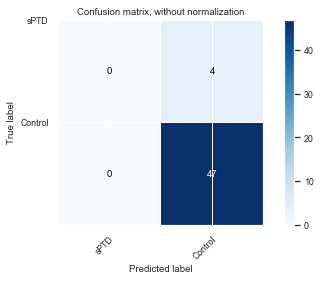

In [15]:
clf = LDA()
clf.fit(xtrain, ytrain)
knn_predict = clf.predict(xtest)
y_test = ytest
y_test = [0 if x == 'sPTD' else x for x in y_test]
y_test = [1 if x == 'Control' else x for x in y_test]
pred = clf.predict(xtest).tolist()
pred = [0 if x == 'sPTD' else x for x in pred]
pred = [1 if x == 'Control' else x for x in pred]
class_names = np.array(['sPTD', 'Control'])
_ = plot_confusion_matrix(y_test, pred, class_names)